In [1]:
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
from nltk.stem import SnowballStemmer
from bs4 import BeautifulSoup
from tqdm.notebook import tqdm
import re
import string
import nltk
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr, kendalltau
import libvoikko

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# !pip install libvoikko
# !pip install voikko

# Data Importing and Sorting

In [3]:
files = os.listdir('corpus')
files.remove('.DS_Store')
files.remove('scores_ru-en.csv')
scaler = MinMaxScaler()
for file_ in files:
  name = file_.split('-')[0] + file_.split('-')[1]
  vars()[name] = pd.read_csv(os.path.join('corpus', file_, 'scores.csv'))
  vars()[name].drop(columns = ['source', 'annotators', 'z-score'], inplace = True)
  vars()[name]['avg-score'] = scaler.fit_transform(vars()[name]['avg-score'].values.reshape(-1,1)) #normalizing values betwewen 0 and 1

In [4]:
english = csen.copy()
for df in [deen, ruen, zhen]:
  english = english.append(df)

In [5]:
finnish = enfi.copy()
chinese = enzh.copy()

In [6]:
english.reset_index(drop = True, inplace = True)

# Baseline assessment before preprocessment

### Finnish & Chinese

In [22]:
# Train, Validation & Test split
# en_train, en_dev = train_test_split(english, shuffle = True, test_size = 0.2, random_state = 7)
# en_dev, en_test = train_test_split(en_dev, shuffle = True, test_size = 0.5, random_state = 7)

fin_train, fin_dev = train_test_split(finnish, shuffle = True, test_size = 0.2, random_state = 7)
fin_dev, fin_test = train_test_split(fin_dev, shuffle = True, test_size = 0.5, random_state = 7)

ch_train, ch_dev = train_test_split(chinese, shuffle = True, test_size = 0.2, random_state = 7)
ch_dev, ch_test = train_test_split(ch_dev, shuffle = True, test_size = 0.5, random_state = 7)

In [7]:
def dataVectorization(train, dev, test):
    """
    Function that receives train, development and test datasets and returns the sets vectorized.
    
    """    
    # Create the CountVectorizer (Bag of words) object
    baseline_encoder = CountVectorizer(max_features = 5000) # Settting limit for computational reasons
    
    train_vectorizer_reference = baseline_encoder.fit_transform(train['reference']).todense()
    train_vectorizer_translation = baseline_encoder.transform(train['translation']).todense()
    train_vectorizer = [train_vectorizer_reference, train_vectorizer_translation]
    
    for i, d in enumerate([dev, test]):
        referece_vectorized = baseline_encoder.transform(d['reference']).todense()
        translation_vectorized = baseline_encoder.transform(d['translation']).todense()
        if i == 0:
            dev_vectorizer = [referece_vectorized, translation_vectorized]
        else:
            test_vectorizer = [referece_vectorized, translation_vectorized]
    
    return train_vectorizer, dev_vectorizer, test_vectorizer

def getBaseline(reference, translation, yLabels):
    """
    Get baseline correlations for the given sets, computing the cosine similarity.
    
    """   
    cos = []
    for i in range(reference.shape[0]):
        cos.append(cosine_similarity(reference[i], translation[i])[0])
    cos = np.array(cos)
    cos.shape = (cos.shape[0],)
    
    return pearsonr(yLabels, cos), kendalltau(yLabels, cos)

In [23]:
fin_train_bl_encoded, fin_dev_bl_encoded, fin_test_bl_encoded = dataVectorization(fin_train, fin_dev, fin_test)
ch_train_bl_encoded, ch_dev_bl_encoded, ch_test_bl_encoded = dataVectorization(ch_train, ch_dev, ch_test)

In [24]:
# Finnish
y_train_label = np.array(fin_train['avg-score'])
finnish_train_pearson, finnish_train_kendalltau = getBaseline(fin_train_bl_encoded[0], fin_train_bl_encoded[1], y_train_label)
print(f'Finnish - Pearson correlation between cosine similarity and score on train set: {finnish_train_pearson[0]} (p-value < 0.001: {finnish_train_pearson[1] < 0.001}); and Kendall Tau: {finnish_train_kendalltau[0]} (p-value < 0.001: {finnish_train_kendalltau[1] < 0.001})')
y_dev_label = np.array(fin_dev['avg-score'])
finnish_dev_pearson, finnish_dev_kendalltau = getBaseline(fin_dev_bl_encoded[0], fin_dev_bl_encoded[1], y_dev_label)
print(f'Finnish - Pearson correlation between cosine similarity and score on validation set: {finnish_dev_pearson[0]} (p-value < 0.001: {finnish_dev_pearson[1] < 0.001}); and Kendall Tau: {finnish_train_kendalltau[0]} (p-value < 0.001: {finnish_train_kendalltau[1] < 0.001})')

# Chinese
y_train_label = np.array(ch_train['avg-score'])
chinese_train_pearson, chinese_train_kendalltau = getBaseline(ch_train_bl_encoded[0], ch_train_bl_encoded[1], y_train_label)
print(f'Chinese - Pearson correlation between cosine similarity and score on train set: {chinese_train_pearson[0]} (p-value < 0.001: {chinese_train_pearson[1] < 0.001}); and Kendall Tau: {chinese_train_kendalltau[0]} (p-value < 0.001: {chinese_train_kendalltau[1] < 0.001})')
y_dev_label = np.array(ch_dev['avg-score'])
chinese_dev_pearson, chinese_dev_kendalltau = getBaseline(ch_dev_bl_encoded[0], ch_dev_bl_encoded[1], y_dev_label)
print(f'Chinese - Pearson correlation between cosine similarity and score on validation set: {chinese_dev_pearson[0]} (p-value < 0.001: {chinese_dev_pearson[1] < 0.001}); and Kendall Tau: {chinese_train_kendalltau[0]} (p-value < 0.001: {chinese_train_kendalltau[1] < 0.001})')

Finnish - Pearson correlation between cosine similarity and score on train set: 0.44505469485853616 (p-value < 0.001: True); and Kendall Tau: 0.29043657889118873 (p-value < 0.001: True)
Finnish - Pearson correlation between cosine similarity and score on validation set: 0.4587223249911555 (p-value < 0.001: True); and Kendall Tau: 0.29043657889118873 (p-value < 0.001: True)
Chinese - Pearson correlation between cosine similarity and score on train set: 0.14019816862465778 (p-value < 0.001: True); and Kendall Tau: 0.11768872321881868 (p-value < 0.001: True)
Chinese - Pearson correlation between cosine similarity and score on validation set: 0.0627879376611599 (p-value < 0.001: False); and Kendall Tau: 0.11768872321881868 (p-value < 0.001: True)


# Cleaning the corpus

In [8]:
def clean(text_list,
          lower = False,
          keep_numbers = False,
          keep_expression = False,
          remove_char = False,
          remove_stop = False,
          remove_tag = False,
          lemmatize = False,
          stemmer = False,
          english = True
          ):
    """
    Function that a receives a list of strings and preprocesses it.
    
    :param text_list: List of strings.
    :param lemmatize: Tag to apply lemmatization if True.
    :param stemmer: Tag to apply the stemmer if True.
    """
    if english:
        lang = 'english'
    else:
        lang = 'finnish'
    
    stop = set(stopwords.words(lang))
    stem = SnowballStemmer(lang)
    
    updates = []
    for j in range(len(text_list)):
        
        text = text_list[j]
        
        #LOWERCASE TEXT
        if lower:
            text = text.lower()
            
        #KEEP NUMBERS AS TOKENS
        if not keep_numbers:
            text = re.sub("[\d+]", 'X', text)
        
        #KEEP '?' and '!' AS TOKENS
        if not keep_expression:
            text = re.sub("[\?|\!]", 'EXPRESSION', text)
            
        #REMOVE TAGS
        if remove_tag:
            text = BeautifulSoup(text).get_text()
            
        #REMOVE THAT IS NOT TEXT
        if remove_char:
            text = re.sub("[^a-zA-Z]", ' ', text)
        
        #REMOVE STOP WORDS
        if remove_stop:
            text = ' '.join([word for word in text.split(' ') if word not in stop])
        
        #LEMMATIZATION
        if lemmatize:
            if english:
                lemma = WordNetLemmatizer()
                text = " ".join(lemma.lemmatize(word) for word in text.split())
        
        #STEMMER
        if stemmer:
            text = " ".join(stem.stem(word) for word in text.split())
        
        updates.append(text)
        
    return updates

def clean_ch(text_list, keep_numbers=False, remove_punctuation=False, remove_stop = False, stopwords_set='merged'):
    """
    Function that removes chinese stopwords
    
    :param stopwords_set: remove words of both sets (merged), just the 1st (fst) or just the second (snd) 
    """
    updates = []
    
    zh_stopwords1 = [line.strip() for line in open('chinese_stopwords/chinese_stopwords1.txt', 'r', encoding='utf-8').readlines()]
    zh_stopwords2 = [line.strip() for line in open('chinese_stopwords/chinese_stopwords2.txt', 'r', encoding='utf-8').readlines()]
    
    if stopwords_set == 'merged':
        stop = list(set(zh_stopwords1 + zh_stopwords2))
    elif stopwords_set == 'fst':
        stop = zh_stopwords1
    elif stopwords_set == 'snd':
        stop = zh_stopwords2

    for j in range(len(text_list)):
        
        text = text_list[j]
        
        #KEEP NUMBERS AS TOKENS
        if keep_numbers:
            text = re.sub("[\d+]", 'X', text)
        
        # REMOVE PUNCTUATION
        if remove_punctuation:
            # https://stackoverflow.com/questions/36640587/how-to-remove-chinese-punctuation-in-python
            punc = "！？｡。＂＃＄％＆＇（）＊＋，－／：；＜＝＞＠［＼］＾＿｀｛｜｝～｟｠｢｣､、〃》「」『』【】〔〕〖〗〘〙〚〛〜〝〞〟〰〾〿–—‘’‛“”„‟…‧﹏."
            text = re.sub(r"[%s]+" %punc, "", text)
        
        # REMOVE STOP WORDS
        if remove_stop:
            text = ' '.join([word for word in text.split(' ') if word not in stop])
            
        updates.append(text)
        
    return updates

In [9]:
parameters = {'lower': [True, False],
              'keep_numbers': [True, False],
              'keep_expression': [True, False],
              'remove_char': [True, False],
              'remove_stop': [True, False],
              'remove_tag': [True, False],
              'lemmatize': [False],
              'stemmer': [True, False]}

parameters = pd.DataFrame(list(ParameterGrid(parameters)))

In [11]:
for conf in range(parameters.shape[0]):
    sets = ['train', 'dev']
    cleaned_data = pd.DataFrame()
    cleaned_data['avg-score'] = finnish['avg-score']
    for column in ['reference', 'translation']:
        cleaned_data[column] = clean(finnish[column],
                                    lower = parameters.loc[conf, 'lower'],
                                    keep_numbers = parameters.loc[conf, 'keep_numbers'],
                                    keep_expression = parameters.loc[conf, 'keep_expression'],
                                    remove_char = parameters.loc[conf, 'remove_char'],
                                    remove_stop = parameters.loc[conf, 'remove_stop'],
                                    remove_tag = parameters.loc[conf, 'remove_tag'],
                                    lemmatize = parameters.loc[conf, 'lemmatize'],
                                    stemmer = parameters.loc[conf, 'stemmer'],
                                    english=False)
    
    fin_train, fin_dev = train_test_split(cleaned_data, shuffle = True, test_size = 0.2, random_state = 7)
    fin_dev, fin_test = train_test_split(fin_dev, shuffle = True, test_size = 0.5, random_state = 7)
    
    fin_train_bl_encoded, fin_dev_bl_encoded, fin_test_bl_encoded = dataVectorization(fin_train, fin_dev, fin_test)
    
    y_train_label = np.array(fin_train['avg-score'])
    finnish_train_pearson, finnish_train_kendalltau = getBaseline(fin_train_bl_encoded[0], fin_train_bl_encoded[1], y_train_label)
    parameters.loc[conf, ['pearson_train', 'kendal_train']] = finnish_train_pearson[0], finnish_train_kendalltau[0]
    
    y_dev_label = np.array(fin_dev['avg-score'])
    finnish_dev_pearson, finnish_dev_kendalltau = getBaseline(fin_dev_bl_encoded[0], fin_dev_bl_encoded[1], y_dev_label)
    parameters.loc[conf, ['pearson_dev', 'kendal_dev']] = finnish_dev_pearson[0], finnish_dev_kendalltau[0]
        
parameters.to_csv('grid_parameters_finnish.csv')

keep_expression        True
keep_numbers           True
lemmatize             False
lower                 False
remove_char           False
remove_stop           False
remove_tag            False
stemmer               False
pearson_train      0.445055
kendal_train       0.290437
pearson_dev        0.458722
kendal_dev          0.31621
Name: 31, dtype: object
0.44505469485853616 0.29043657889118873
0.4587223249911555 0.31620991479123983


In [25]:
finnishDf = pd.read_csv('grid_parameters_finnish.csv', index_col = 0)

In [26]:
finnishDf['train_avg'] = finnishDf[['pearson_train', 'kendal_train']].mean(axis=1)
finnishDf['dev_avg'] = finnishDf[['pearson_dev', 'kendal_dev']].mean(axis=1)

In [27]:
finnishDf.sort_values(f'train_avg', ascending=False).iloc[0:5,]

keep_expression  keep_numbers  lemmatize  lower  remove_char  \
118            False         False      False  False         True   
116            False         False      False  False         True   
102            False         False      False   True         True   
100            False         False      False   True         True   
54              True         False      False  False         True   

     remove_stop  remove_tag  stemmer  pearson_train  kendal_train  \
118        False       False     True       0.496241      0.320892   
116        False        True     True       0.496241      0.320892   
102        False       False     True       0.496241      0.320892   
100        False        True     True       0.496241      0.320892   
54         False       False     True       0.495549      0.320471   

     pearson_dev  kendal_dev  train_avg   dev_avg  
118     0.529824    0.367403   0.408566  0.448614  
116     0.529824    0.367403   0.408566  0.448614  
102     0.529824    0.367403   0.408566  0.448614  
100     0.529824    0.367403   0.408566  0.448614  
54      0.530620    0.369137   0.408010  0.449879

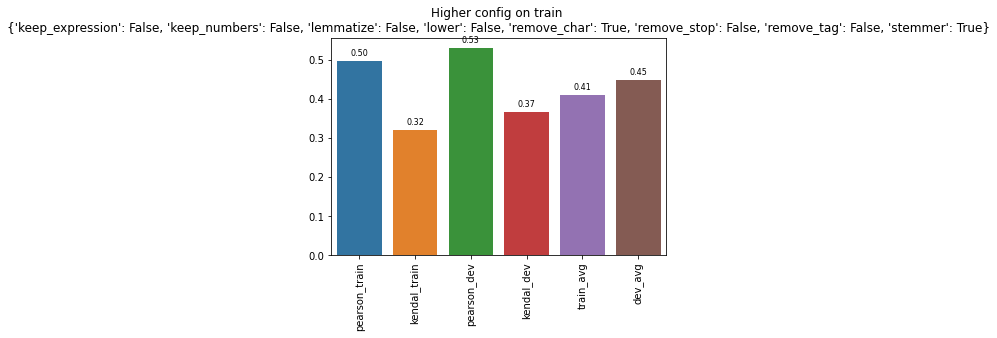

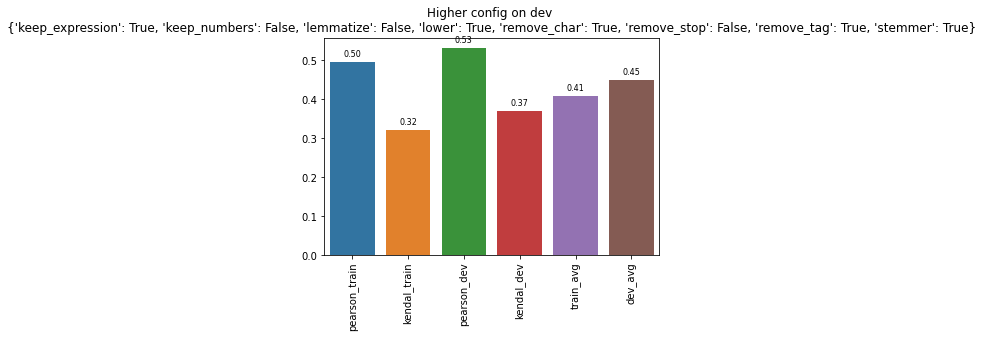

In [28]:
for data_type in ['train', 'dev']:
    fig = sns.barplot(finnishDf.sort_values(f'{data_type}_avg', ascending=False).iloc[0,8:].index,
                      finnishDf.sort_values(f'{data_type}_avg', ascending=False).iloc[0,8:].values)
    # Iterrating over the bars one-by-one
    for bar in fig.patches:
        fig.annotate(format(bar.get_height(), '.2f'), 
                       (bar.get_x() + bar.get_width() / 2, 
                        bar.get_height()), ha='center', va='center',
                       size=8, xytext=(0, 8),
                       textcoords='offset points')
    fig.set_xticklabels(fig.get_xticklabels(),rotation=90)
    fig.set_title(f'Higher config on {data_type} \n' + str(dict(finnishDf.sort_values(f'{data_type}_avg', ascending=False).iloc[0, 0:8])))
    plt.show()

In [29]:
parameters_ch = {'keep_numbers': [True, False],
                  'remove_punctuation': [True, False],
                  'remove_stop': [True, False],
                  'stopwords_set': ['merged', 'fst', 'snd']}

parameters_ch = pd.DataFrame(list(ParameterGrid(parameters_ch)))

In [ ]:
for conf in range(parameters_ch.shape[0]):
    sets = ['train', 'dev']
    cleaned_data = pd.DataFrame()
    cleaned_data['avg-score'] = chinese['avg-score']
    for column in ['reference', 'translation']:
        cleaned_data[column] = clean_ch(chinese[column],
                                    keep_numbers = parameters_ch.loc[conf, 'keep_numbers'],
                                    remove_punctuation = parameters_ch.loc[conf, 'remove_punctuation'],
                                    remove_stop = parameters_ch.loc[conf, 'remove_stop'],
                                    stopwords_set = parameters_ch.loc[conf, 'stopwords_set'])
    
    ch_train, ch_dev = train_test_split(cleaned_data, shuffle = True, test_size = 0.2, random_state = 7)
    ch_dev, ch_test = train_test_split(ch_dev, shuffle = True, test_size = 0.5, random_state = 7)
    
    ch_train_bl_encoded, ch_dev_bl_encoded, ch_test_bl_encoded = dataVectorization(ch_train, ch_dev, ch_test)
    
    y_train_label = np.array(ch_train['avg-score'])
    chinese_train_pearson, chinese_train_kendalltau = getBaseline(ch_train_bl_encoded[0], ch_train_bl_encoded[1], y_train_label)
    parameters_ch.loc[conf, ['pearson_train', 'kendal_train']] = chinese_train_pearson[0], chinese_train_kendalltau[0]
    
    y_dev_label = np.array(ch_dev['avg-score'])
    chinese_dev_pearson, chinese_dev_kendalltau = getBaseline(ch_dev_bl_encoded[0], ch_dev_bl_encoded[1], y_dev_label)
    parameters_ch.loc[conf, ['pearson_dev', 'kendal_dev']] = chinese_dev_pearson[0], chinese_dev_kendalltau[0]
    
parameters_ch.to_csv('grid_parameters_chinese.csv')

In [30]:
chineseDf = pd.read_csv('grid_parameters_chinese.csv', index_col = 0)

In [31]:
chineseDf['train_avg'] = (chineseDf['pearson_train'] + chineseDf['kendal_train']) / 2
chineseDf['dev_avg'] = (chineseDf['pearson_dev'] + chineseDf['kendal_dev']) / 2

In [33]:
chineseDf.sort_values(f'train_avg', ascending=False).iloc[0:5,]

keep_numbers  remove_punctuation  remove_stop stopwords_set  \
9           True               False        False        merged   
10          True               False        False           fst   
11          True               False        False           snd   
8           True               False         True           snd   
6           True               False         True        merged   

    pearson_train  kendal_train  pearson_dev  kendal_dev  train_avg   dev_avg  
9        0.142854      0.119220     0.065018    0.052359   0.131037  0.058689  
10       0.142854      0.119220     0.065018    0.052359   0.131037  0.058689  
11       0.142854      0.119220     0.065018    0.052359   0.131037  0.058689  
8        0.141367      0.118394     0.072398    0.058600   0.129881  0.065499  
6        0.141189      0.118187     0.072398    0.058600   0.129688  0.065499

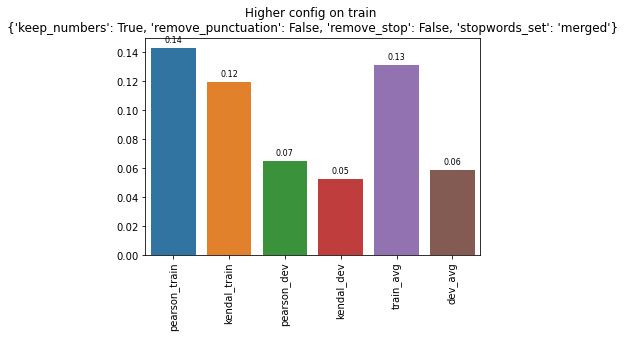

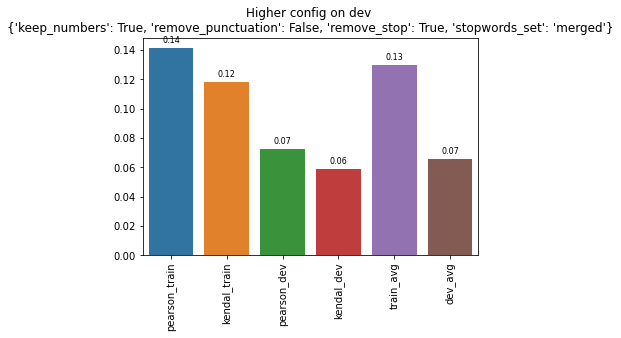

In [34]:
for data_type in ['train', 'dev']:
    fig = sns.barplot(chineseDf.sort_values(f'{data_type}_avg', ascending=False).iloc[0,4:].index,
                      chineseDf.sort_values(f'{data_type}_avg', ascending=False).iloc[0,4:].values)
    # Iterrating over the bars one-by-one
    for bar in fig.patches:
        fig.annotate(format(bar.get_height(), '.2f'), 
                       (bar.get_x() + bar.get_width() / 2, 
                        bar.get_height()), ha='center', va='center',
                       size=8, xytext=(0, 8),
                       textcoords='offset points')
    fig.set_xticklabels(fig.get_xticklabels(),rotation=90)
    fig.set_title(f'Higher config on {data_type} \n' + str(dict(chineseDf.sort_values(f'{data_type}_avg', ascending=False).iloc[0, 0:4])))
    plt.show()